# Markov Chain Monte Carlo (MCMC) sampling
This code uses the Metropolis–Hastings sampling algorithm (an MCMC method) to design a posterior distribution for each variable in the provided Gaussian model

## Step 1: Import packages

In [1]:
import time, sys, os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import scipy.stats as stats
from IPython.display import display, Math, Latex

## Step 2: Read in data

In [2]:
data = ascii.read('mcmc_data.dat')
nu = data['col1']
phi = data['col2']
err = data['col3']

## Step 3: Set up the model
The Gaussian model used here takes the form: 

$$ G(x) = \frac{A}{\alpha_D} \sqrt{\frac{\ln 2}{\pi}} \exp \left({\frac{-(\ln 2)(x-\mu)^2}{\alpha^2_D}}\right) $$

and the posterior distribution is calculated as 

$$ \mathrm{ln}(\mathcal{L}_{posterior}) = \mathrm{ln} (\mathcal{L}_{likelihood}) + \mathrm{ln}(\mathcal{L}_{prior}) $$

with the likelihood function

$$  \mathcal{L}_{likelihood}(y_i, m_i, \sigma_i) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi}\sigma_i} \exp \left({-(\frac{y_i - m_i}{\sqrt{2}\sigma_i})^2}\right)$$

and the prior

$$ \mathcal{L}_{prior}(x_i, \sigma_\mu, \mu_\mu, \sigma_{\alpha_D}, \mu_{\alpha_D}, \sigma_{A}, \mu_A) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi}\sigma_\mu} \exp \left({-\left(\frac{x_i - \mu_\mu}{\sqrt{2}\sigma_\mu}\right)^2}\right) \times \frac{1}{\sqrt{2\pi}\sigma_{\alpha_D}} \exp \left({-\left(\frac{x_i - \mu_{\alpha_D}}{\sqrt{2}\sigma_{\alpha_D}}\right)^2}\right) \times \frac{1}{\sqrt{2\pi}\sigma_{A}} \exp \left({-\left(\frac{x_i - \mu_A}{\sqrt{2}\sigma_A}\right)^2}\right) $$

where $m_i = G(x_i, \mu, \alpha_D, A)$ and $\sigma_i$ is the standard deviation of the data points due to measurement uncertainty

In [3]:
# The Gaussian Model
def G(x, mu, alpha_D, A):
    return (A/alpha_D)*np.sqrt(np.log(2)/np.pi)*np.exp(-(np.log(2)*(x-mu)**2)/(alpha_D**2))

# Log-likelihood 
def ln_like(params, x, y, y_err):
    mu, alpha_D, A = params
    return -0.5 * np.sum(((y - G(x, mu, alpha_D, A))/y_err)**2)

# Log-prior distributions
def ln_prior(params, mu_0, sigma_mu, alpha_D_0, sigma_alpha_D, A_0, sigma_A):
    mu, alpha_D, A = params
    # Assumes each parameter to be fit for is represented by a normal distribution
    lp = stats.norm.logpdf(mu, loc=mu_0, scale=sigma_mu)  
    # Add on for alpha_D
    lp += stats.norm.logpdf(alpha_D, loc=alpha_D_0, scale=sigma_alpha_D)
    # Add on for A
    lp += stats.norm.logpdf(A, loc=A_0, scale=sigma_A)
    return lp

# Log-posterior distribution
def ln_prob(params, x, y, y_err, mu_0, sigma_mu, alpha_D_0, sigma_alpha_D, A_0, sigma_A):
    lp = ln_prior(params, mu_0, sigma_mu, alpha_D_0, sigma_alpha_D, A_0, sigma_A) # log-prior
    ll = ln_like(params, x, y, y_err)                                             # log-likelihood 
    return lp + ll

## Step 4: Set up the MCMC initial parameters and run the sampling

In [4]:
%%time

# Initial parameter values
mu_0 = 45.0           # Initial guess for mu
sigma_mu = 1.0        # Initial guess for standard deviation of mu (assuming normal dist.)
alpha_D_0 = 10.0      # Initial guess for alpha_D
sigma_alpha_D = 1.0   # Initial guess for standard deviation of alpha_D
A_0 = 10.0            # Initial guess for A 
sigma_A = 1.0         # Initial guess for standard deviation of A 

# The MCMC parameters
n_params = 3     # Number of parameters to fit for
n_walkers = 128  # Number of walkers to be used
n_steps = 10000  # Maximum number of steps for the walkers to take
burnin = 100     # Number of iterations to be discarded

# Initialize the walkers and the sampler
params_initial = np.array([mu_0, alpha_D_0, A_0])
params_walkers = np.random.normal(loc=params_initial, scale=0.1, size=(n_walkers, n_params))
sampler = np.zeros((n_walkers, n_steps-burnin, n_params))

# Run the MCMC sampling
for i in range(n_steps):
    # Update each walker with each step
    for j in range(n_walkers):
        # Propose a new parameter set
        params_proposed = np.random.normal(loc=params_walkers[j], scale=0.1, size=n_params)
        # Calculate the acceptance probability
        log_alpha = ln_prob(params_proposed, nu, phi, err, mu_0, sigma_mu, alpha_D_0, sigma_alpha_D, A_0, sigma_A) - ln_prob(params_walkers[j], nu, phi, err, mu_0, sigma_mu, alpha_D_0, sigma_alpha_D, A_0, sigma_A)
        alpha = min(1.0, np.exp(log_alpha))
        # Accept or reject the proposed parameter set
        if np.random.rand() < alpha:
            params_walkers[j] = params_proposed
        # Save the parameter values to the sampler
        sampler[j, i-burnin, :] = params_walkers[j]

<timed exec>:28: RuntimeWarning: overflow encountered in exp


CPU times: total: 18min 47s
Wall time: 19min 13s


## Step 5: Plot MCMC chains to check for convergence

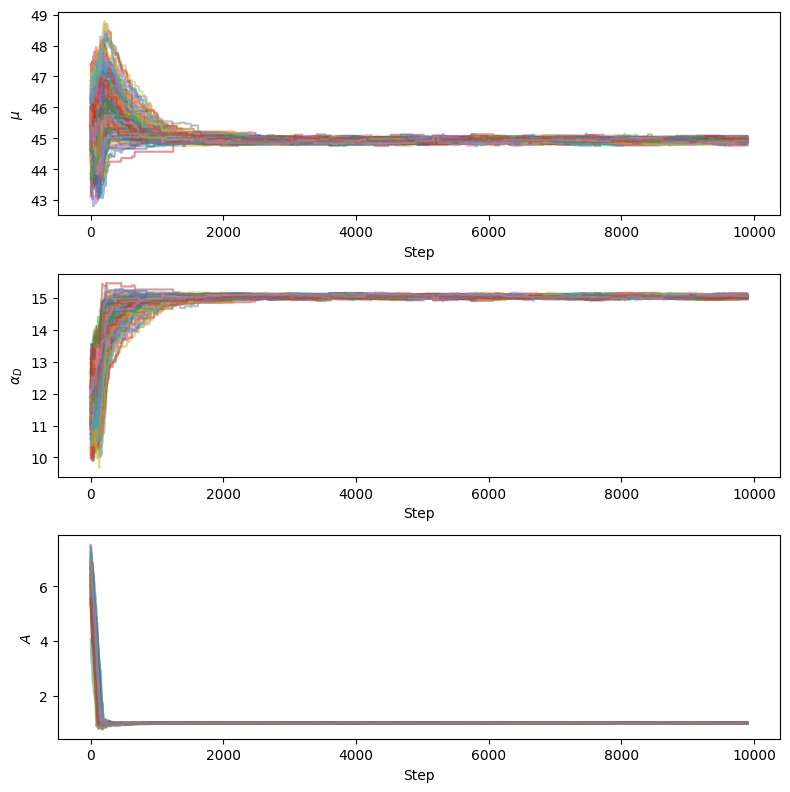

In [5]:
# Plot the Markov Chain history for each parameter
fig, axes = plt.subplots(nrows=n_params, ncols=1, figsize=(8, 8))
for i in range(n_params):
    for j in range(n_walkers):
        axes[i].plot(sampler[j, :, i], alpha=0.5)
    axes[i].set_xlabel('Step')

axes[0].set_ylabel(r"$\mu$")
axes[1].set_ylabel(r"$\alpha_{D}$")
axes[2].set_ylabel("$A$")
plt.tight_layout()
plt.show()

## Step 6: Display the median and 1$\sigma$ errors from the posterior distribution

In [6]:
# Flatten the sampler to a 2D array
samples = sampler[:, burnin:, :].reshape((-1, n_params))

# Compute the median and 1-sigma uncertainty intervals for each parameter
medians = np.median(samples, axis=0)
lowers = np.percentile(samples, 16, axis=0)
uppers = np.percentile(samples, 84, axis=0)

print("Best-fit parameters:")
labels = [r"\mu", r"\alpha_D", r"A"]
for i in range(len(labels)):
    median, lower, upper = medians[i], medians[i]-lowers[i], uppers[i]-medians[i]
    txt = r"\mathrm{{{0}}} = {1:.3f}_{{-{2:.3f}}}^{{+{3:.3f}}}".format(labels[i], median, lower, upper)
    display(Math(txt))

Best-fit parameters:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Step 7: Plot posterior probability distributions

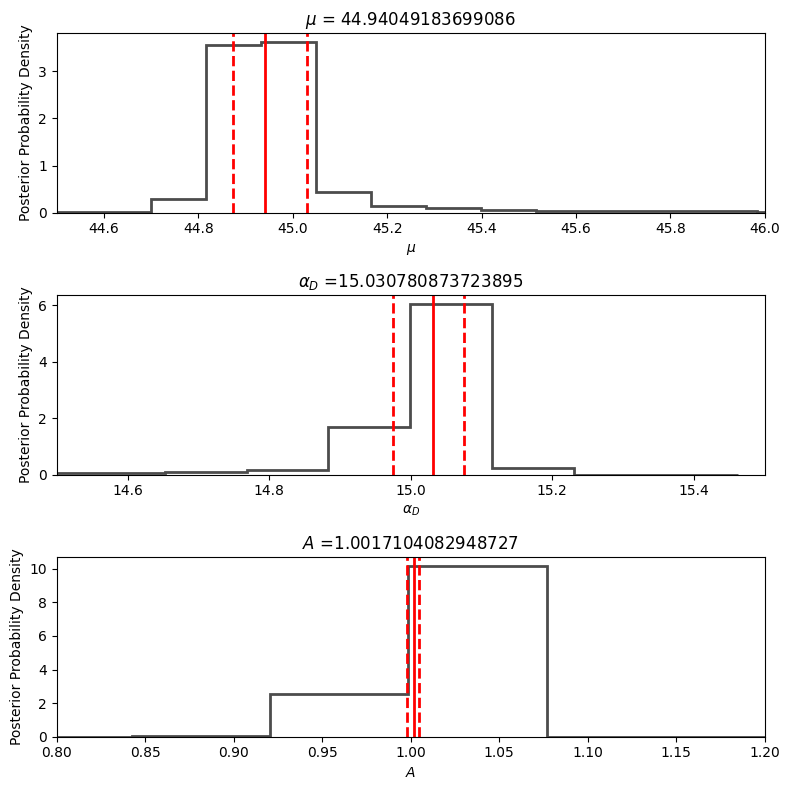

In [7]:
fig, axes = plt.subplots(nrows=n_params, ncols=1, figsize=(8, 8))
for i in range(n_params):
    ax = axes[i]
    ax.hist(samples[:, i], bins=50, density=True, histtype='step', color='black', lw=2, alpha=0.7)
    ax.axvline(medians[i], color='red', linestyle='-', lw=2)
    ax.axvline(lowers[i], color='red', linestyle='--', lw=2)
    ax.axvline(uppers[i], color='red', linestyle='--', lw=2)
    ax.set_ylabel('Posterior Probability Density')
    
axes[0].set_xlabel(r"$\mu$")
axes[1].set_xlabel(r"$\alpha_{D}$")
axes[2].set_xlabel("$A$")
axes[0].set_xlim(44.5, 46)
axes[1].set_xlim(14.5, 15.5)
axes[2].set_xlim(0.8, 1.2)

axes[0].set_title(r'$\mu$ = '+str(medians[0]))
axes[1].set_title(r"$\alpha_{D}$ =" +str(medians[1]))
axes[2].set_title("$A$ =" +str(medians[2]))
plt.tight_layout()
plt.show()

## Step 8: Plot the data and fitted model

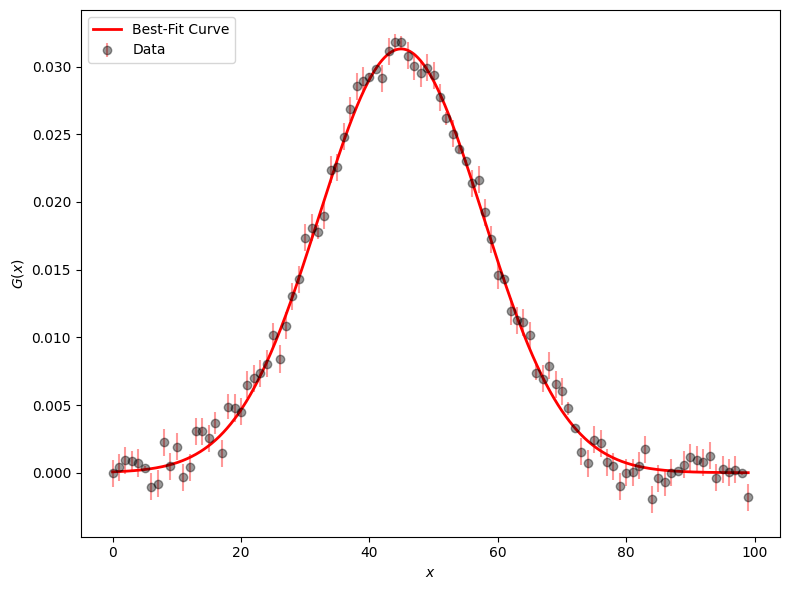

In [8]:
# Generate the best-fit curve using the model function and median (best-fit) parameter values
x_fit = np.linspace(nu.min(), nu.max(), 1000)
y_fit = G(x_fit, medians[0], medians[1], medians[2])

# Plot the best-fit curve and the data
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(nu, phi, yerr=err, fmt='o', 
             alpha=0.4, color='black', ecolor='red', label='Data')
ax.plot(x_fit, y_fit, color='red', lw=2, label='Best-Fit Curve')

ax.legend(loc='upper left')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$G(x)$')
plt.tight_layout()
plt.show()